# Import Dependencies

In [1]:
import re
import pickle
import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy, lemmatizer

from gensim.models import word2vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions from .py files
from web_scrape import get_transcript
from preprocess import clean, preprocess

# Import/Preprocess Data

In [2]:
# Web scrape most recent speeches using our imported 'get_transcript'
goodyear = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-goodyear-az-october-28')
bullhead = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-bullhead-city-az-october-28')
omaha = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-omaha-ne-october-27')
wsalem = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-west-salem-wisconsin-october-27')
lansing = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lansing-michigan-october-27')
martinsburg = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-martinsburg-pa-october-26')
lititz = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lititz-pa-october-26')
allentown = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-allentown-pa-october-26')

In [3]:
# Create corpus
corpus = [goodyear,bullhead,omaha,wsalem,lansing,martinsburg,lititz,allentown]

In [4]:
# Clean all of the speeches in the corpus using our imported 'clean' function
clean_corpus = clean(corpus)

In [5]:
# Preprocess the speeches using our imported 'preprocess' function
processed_corpus = preprocess(clean_corpus)

# Document-Term Matrices

In [6]:
# Countvectorizer
cv = CountVectorizer(stop_words='english')

X_cv = cv.fit_transform(processed_corpus)

df_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

In [18]:
df_cv

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,youtube,yu,yuma,zero,zippo,zone,zoning,zucker,pca-one,pca-two
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.231229,-0.006122
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.148250,1.915976
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.026932,-0.101856
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.066367,-0.061153
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.048296,-0.066011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.008178,-0.072365
9677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.052395,-0.069571
9678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.032897,-0.044047
9679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.082491,-0.081733


In [7]:
# TF_IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(**cv.get_params())

X_tfidf = tfidf_vectorizer.fit_transform(processed_corpus)

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

# PCA

In [8]:
# Instantiate PCA
pca_cv = PCA(n_components=5)
pca_tfidf = PCA(n_components=5)

In [9]:
# Fit both PCAs
pca_cv_result = pca_cv.fit_transform(X_cv.toarray())
pca_tfidf_result = pca_tfidf.fit_transform(X_tfidf.toarray())

In [10]:
# Explained Variance
print(f"Count Vectorizer explained variance: {round(sum(pca_cv.explained_variance_ratio_) * 100,4)}%")
print(f"TFIDF explained variance: {round(sum(pca_tfidf.explained_variance_ratio_) * 100,4)}%")

# Very similar explained variances, let's go with Count Vectorizer

Count Vectorizer explained variance: 7.5%
TFIDF explained variance: 7.5341%


In [12]:
# to understand the importance of each variable in each PC, look at the correlations:
# Use Count Vectorizer due to higher explained variance
df_pca = pd.DataFrame(pca_cv.components_, index = ['PC1','PC2', 'PC3', 'PC4', 'PC5'], columns=cv.get_feature_names())

In [13]:
df_pca

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,york,young,youtube,yu,yuma,zero,zippo,zone,zoning,zucker
PC1,0.001562,-0.001069,-0.000002,0.006949,-0.000063,-0.000403,0.003991,-0.000344,-0.000247,0.000058,...,0.003035,-0.003186,0.000423,-0.000146,-0.000765,-0.000251,-0.000114,0.001453,-0.000242,-0.000120
PC2,0.004419,0.008911,0.001762,-0.002202,-0.000061,-0.000384,0.003517,-0.000043,-0.000163,-0.000123,...,0.001028,0.011540,0.000350,-0.000076,-0.000624,-0.000576,-0.000117,-0.000413,-0.000255,-0.000126
PC3,-0.002811,-0.003653,-0.000741,0.000007,-0.000142,-0.000099,-0.003153,-0.000021,-0.000159,-0.000082,...,0.002675,0.003016,0.000093,-0.000140,0.000030,-0.000665,-0.000089,-0.000248,-0.000168,-0.000088
PC4,0.001325,0.000810,0.000387,-0.005130,0.000057,-0.000964,0.005587,0.000614,-0.000145,-0.000029,...,-0.001805,-0.002829,-0.000274,0.000165,-0.001816,-0.000040,-0.000053,0.000045,-0.000128,-0.000073
PC5,0.000386,0.000064,0.000100,0.000901,-0.000303,0.001596,0.020360,-0.000008,-0.000212,-0.000085,...,-0.003806,-0.001840,-0.000714,-0.000139,0.003447,-0.000893,-0.000122,-0.000485,-0.000263,-0.000125


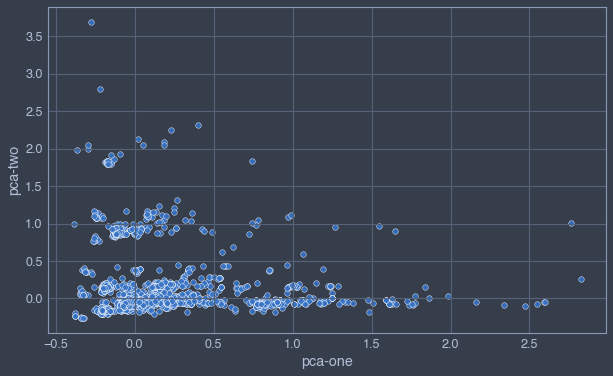

In [14]:
# Visualize
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_cv.shape[0])

# Create columns for seaborn plotting
df_cv['pca-one'] = pca_cv_result[:,0]
df_cv['pca-two'] = pca_cv_result[:,1] 

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df_cv.loc[rndperm,:],
    legend="full",
    alpha=0.9
);

## Scree plot

In [15]:
pca2 = PCA(n_components=15)
pca2.fit(X_cv.toarray())
pcafeatures_train2 = pca2.transform(X_cv.toarray())

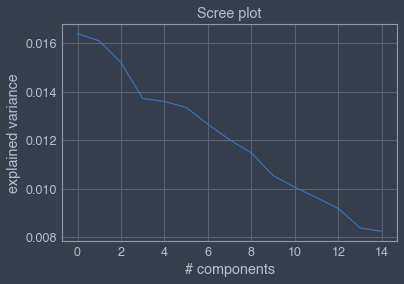

In [16]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot');

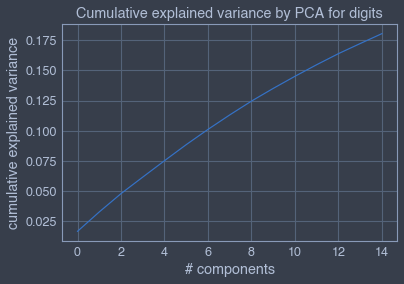

In [17]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');